In [1]:
!pip install statsmodels

In [3]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as ds
import torchvision.transforms as transforms

import lightning as L
from lightning.pytorch.trainer import Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC

import warnings

In [97]:
## 경고 무시
warnings.filterwarnings('ignore')
## train, test 데이터 불러오기
origin_train = pd.read_csv('../train.csv', encoding='cp949')
origin_test = pd.read_csv('../test.csv', encoding='cp949')
train = origin_train
test = origin_test
# display(train)
## 결측치 제거
train = train.dropna()
# data.MonthlyRevenue = data.MonthlyRevenue.fillna(0)
# data.MonthlyMinutes = data.MonthlyMinutes.fillna(0)
## 데이터 전체 개수
# display(len(train))
## 데이터 칼럼 전체 종류 
# display(train.columns.unique())
## 빈 데이터 총합 
# display(train.isnull().sum())
## 중복 데이터 총합
# display(train.duplicated().sum())
## 데이터 값 설명
# display(train.describe())
## 데이터 정보
# display(train.info())
## 데이터 종류가 object인 칼럼 추려내기
objects = []
train.dtypes
for idx in range(len(train.columns)):
    if train.dtypes[idx] == object:
        objects.append(train.columns[idx])
# print(objects)

def convert_to_category(dfs: list):
    dfs.Churn = dfs.Churn.astype('int')
    dfs.ServiceArea = dfs.ServiceArea.astype('category')
    dfs.ChildrenInHH = dfs.ChildrenInHH.astype('category')
    dfs.HandsetRefurbished = dfs.HandsetRefurbished.astype('category')
    dfs.HandsetWebCapable = dfs.HandsetWebCapable.astype('category')
    dfs.TruckOwner = dfs.TruckOwner.astype('category')
    dfs.RVOwner = dfs.RVOwner.astype('category')
    dfs.Homeownership = dfs.Homeownership.astype('category')
    dfs.BuysViaMailOrder = dfs.BuysViaMailOrder.astype('category')
    dfs.RespondsToMailOffers = dfs.RespondsToMailOffers.astype('category')
    dfs.OptOutMailings = dfs.OptOutMailings.astype('category')
    dfs.NonUSTravel = dfs.NonUSTravel.astype('category')
    dfs.OwnsComputer = dfs.OwnsComputer.astype('category')
    dfs.NewCellphoneUser = dfs.NewCellphoneUser.astype('category')
    dfs.NotNewCellphoneUser = dfs.NotNewCellphoneUser.astype('category')
    dfs.OwnsMotorcycle = dfs.OwnsMotorcycle.astype('category')
    dfs.HandsetPrice = dfs.HandsetPrice.astype('category')
    dfs.MadeCallToRetentionTeam = dfs.MadeCallToRetentionTeam.astype('category')
    dfs.CreditRating = dfs.CreditRating.astype('category')
    dfs.PrizmCode = dfs.PrizmCode.astype('category')
    dfs.Occupation = dfs.Occupation.astype('category')
    dfs.MaritalStatus = dfs.MaritalStatus.astype('category')

    return dfs

def convert_category_into_integer(df: pd.DataFrame, columns: list):
    label_encoders = {}
    for column in columns:
        label_encoder = LabelEncoder()
        df.loc[:, column] = label_encoder.fit_transform(df[column])

        label_encoders.update({column: label_encoder})
    
    return df, label_encoders


## 범주형 변수 인코딩하기
train, _ = convert_category_into_integer(train, objects)
test, _ = convert_category_into_integer(test, objects)

## 데이터 종류가 object인 칼럼을 카테고리화 하기
train = convert_to_category(train)
test = convert_to_category(test)
## 타겟 변수 정의
target = 'Churn'

## train 데이터 분할하기
seed = 0
train, valid = train_test_split(train, test_size=0.4, random_state=seed)
display(len(train), len(valid), len(test))
## 특성 스케일링
compare_columns = train.columns.difference(objects)
standard_scaler = StandardScaler()
train.loc[:, compare_columns] = standard_scaler.fit_transform(train.loc[:, compare_columns])
valid.loc[:, compare_columns] = standard_scaler.transform(valid.loc[:, compare_columns])
test.loc[:, compare_columns] = standard_scaler.transform(test.loc[:, compare_columns])
display(train)

train = pd.DataFrame(train, columns=origin_train.columns)
# df_train.corr()

29851

19901

20000

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
29054,0.255207,0,-0.678172,-0.805930,-1.121572,0.042489,-0.210255,-0.146895,-0.028357,0.218037,...,-0.192093,0.511189,0,-0.134864,15,0,1,3,4,2
42360,1.166973,0,-0.964316,-0.042906,-1.540832,2.200437,-0.402346,-0.146895,0.816273,0.153821,...,-0.192093,-1.410137,0,-0.134864,15,0,2,0,3,1
27980,0.177439,0,0.848380,0.966923,0.555466,0.151476,0.982731,-0.074287,-0.324372,0.282252,...,-0.192093,-1.410137,0,-0.134864,15,0,3,0,3,1
12132,-0.903111,0,-0.121254,1.419086,0.555466,-0.389100,-0.402346,-0.146895,-1.038756,0.030330,...,-0.192093,1.471851,0,-0.134864,3,0,5,2,3,2
11491,-0.945496,1,-0.556572,-0.811582,-0.702313,-0.171126,-0.301246,-0.146895,0.070315,-0.068462,...,-0.192093,1.471851,0,-0.134864,8,0,0,2,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21666,-0.264940,0,-0.435651,-0.208699,-0.702313,-0.280113,-0.099045,-0.146895,0.733389,0.731759,...,-0.192093,0.831409,0,-0.134864,15,0,0,0,3,2
46929,1.456493,1,-0.275853,-0.238843,0.429688,0.151476,-0.402346,-0.146895,2.095059,0.339058,...,-0.192093,1.151630,0,-0.134864,14,0,4,0,3,1
43543,1.240486,1,-0.514532,0.141727,-0.073423,-0.389100,-0.382126,-0.122692,0.800486,0.010572,...,-0.192093,-1.089916,0,-0.134864,15,0,1,0,3,2
44528,1.301128,0,2.004708,1.241989,0.513540,6.734306,2.246487,-0.146895,3.267280,1.080003,...,3.437132,-1.410137,0,-0.134864,14,0,2,0,3,1


In [98]:
# 범주형 데이터 제외 시킨 칼럼들
compare_columns = train.columns.difference(objects)
string = f'{target} ~ {" + ".join(compare_columns)}'
# 로지스틱 회귀 모델 정의
model = LogisticRegression().fit(train.drop(columns=['Churn']), train.Churn)
# 모델 예측 값
(model.predict(valid.drop(columns=['Churn'])) == valid.Churn).mean()

0.7115722827998593

In [99]:
tree = DecisionTreeClassifier()
tree.fit(train.drop(columns=['Churn']), train.Churn)
train_acc = (tree.predict(train.drop(columns='Churn')) == train.Churn).mean()
test_acc = (tree.predict(test.drop(columns='Churn')) == test.Churn).mean()
display(train_acc, test_acc)

1.0

0.70015

In [100]:
## SVM
# 이상치 처리에 민감하지 않음
# 복잡한 데이터셋 처리 가능
for kernel in ('linear', 'poly', 'rbf', 'sigmoid'):
    svc = SVC(kernel=kernel, random_state=seed)
    train1 = train.sample(n=300, random_state=seed)
    valid1 = valid.sample(n=300, random_state=seed)
    svc.fit(train1.drop(columns='Churn'), train1.Churn)
    # display((svc.predict(train1.drop(columns='Churn')) == train1.Churn).mean())
    # display((svc.predict(valid1.drop(columns='Churn')) == valid1.Churn).mean())
    result = (svc.predict(train1.drop(columns='Churn')) == train1.Churn).mean()
    print(kernel, result)
# result

linear 0.7666666666666667
poly 0.6833333333333333
rbf 0.6833333333333333
sigmoid 0.6


Index(['ActiveSubs', 'AdjustmentsToCreditRating', 'AgeHH1', 'AgeHH2',
       'BlockedCalls', 'CallForwardingCalls', 'CallWaitingCalls',
       'CurrentEquipmentDays', 'CustomerCareCalls', 'CustomerID',
       'DirectorAssistedCalls', 'DroppedBlockedCalls', 'DroppedCalls',
       'HandsetModels', 'Handsets', 'InboundCalls', 'IncomeGroup',
       'MonthlyMinutes', 'MonthlyRevenue', 'MonthsInService',
       'OffPeakCallsInOut', 'OutboundCalls', 'OverageMinutes',
       'PeakCallsInOut', 'PercChangeMinutes', 'PercChangeRevenues',
       'ReceivedCalls', 'ReferralsMadeBySubscriber', 'RetentionCalls',
       'RetentionOffersAccepted', 'RoamingCalls', 'ThreewayCalls',
       'TotalRecurringCharge', 'UnansweredCalls', 'UniqueSubs'],
      dtype='object')

30640

CustomerID
3000002    1
3267342    1
3267438    1
3267426    1
3267410    1
          ..
3132538    1
3132534    1
3132482    1
3132474    1
3399942    1
Name: count, Length: 30640, dtype: int64

,count,mean,std,min,25%,50%,75%,max
CustomerID,30640.0,3.201598e+06,112890.425533,3000002.00,3.104708e+06,3199570.0,3300875.00,3399942.00
Churn,30640.0,2.834856e-01,0.450697,0.00,0.000000e+00,0.0,1.00,1.00
MonthlyRevenue,30640.0,4.045584e+01,16.820820,-6.17,3.032750e+01,37.1,50.45,99.99
MonthlyMinutes,30640.0,2.860310e+02,232.474217,0.00,1.010000e+02,230.0,413.25,999.00
TotalRecurringCharge,30640.0,4.096260e+01,17.809278,-6.00,3.000000e+01,40.0,50.00,120.00
DirectorAssistedCalls,30640.0,2.282947e-01,0.372382,0.00,0.000000e+00,0.0,0.25,1.49
OverageMinutes,30640.0,6.430255e+00,11.715520,0.00,0.000000e+00,0.0,8.00,49.00
RoamingCalls,30640.0,6.308943e-01,2.647842,0.00,0.000000e+00,0.0,0.10,74.20
PercChangeMinutes,30640.0,-6.604504e+00,117.591218,-498.00,-5.500000e+01,-4.0,41.00,498.00
PercChangeRevenues,30640.0,-7.327154e-01,14.573314,-185.60,-2.700000e+00,-0.2,0.50,170.30


18384

12256

20000

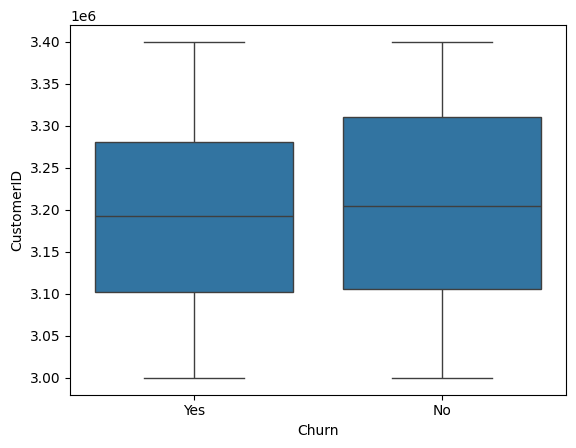

In [194]:
## 경고 무시
warnings.filterwarnings('ignore')
## train, test 데이터 불러오기
origin_train = pd.read_csv('../train.csv', encoding='cp949')
origin_test = pd.read_csv('../test.csv', encoding='cp949')
origin_train = origin_train.query('MonthlyRevenue < 100')
origin_train = origin_train.query('MonthlyMinutes < 1000')
origin_train = origin_train.query('-500 < PercChangeMinutes < 500')
origin_train = origin_train.query('-1000 < CurrentEquipmentDays < 1000')
# origin_train = origin_train.query('TotalRecurringCharge < 80')
origin_train = origin_train.query('DirectorAssistedCalls < 1.5')
origin_train = origin_train.query('OverageMinutes < 50')
# origin_train = origin_train.query('RoamingCalls < 0.3')
# origin_train = origin_train.query('Handsets < 5.0')
# origin_train = origin_train.query('HandsetModels < 50')
# origin_train = origin_train.query('RetentionCalls <= 1.0')
# origin_train = origin_train.query('AdjustmentsToCreditRating <= 5')
train = origin_train
test = origin_test
# display(train)
## 결측치 제거
train = train.dropna()
# data.MonthlyRevenue = data.MonthlyRevenue.fillna(0)
# data.MonthlyMinutes = data.MonthlyMinutes.fillna(0)
## 데이터 전체 개수
# display(len(train))
## 데이터 칼럼 전체 종류 
# display(train.columns.unique())
## 빈 데이터 총합 
# display(train.isnull().sum())
## 중복 데이터 총합
# display(train.duplicated().sum())
## 데이터 값 설명
# display(train.describe())
## 데이터 정보
# display(train.info())
## 데이터 종류가 object인 칼럼 추려내기
objects = []
for idx in range(len(train.columns)):
    if train.dtypes[idx] == object:
        objects.append(train.columns[idx])
# print(objects)

def convert_to_category(dfs: list):
    dfs.Churn = dfs.Churn.astype('int')
    dfs.ServiceArea = dfs.ServiceArea.astype('category')
    dfs.ChildrenInHH = dfs.ChildrenInHH.astype('category')
    dfs.HandsetRefurbished = dfs.HandsetRefurbished.astype('category')
    dfs.HandsetWebCapable = dfs.HandsetWebCapable.astype('category')
    dfs.TruckOwner = dfs.TruckOwner.astype('category')
    dfs.RVOwner = dfs.RVOwner.astype('category')
    dfs.Homeownership = dfs.Homeownership.astype('category')
    dfs.BuysViaMailOrder = dfs.BuysViaMailOrder.astype('category')
    dfs.RespondsToMailOffers = dfs.RespondsToMailOffers.astype('category')
    dfs.OptOutMailings = dfs.OptOutMailings.astype('category')
    dfs.NonUSTravel = dfs.NonUSTravel.astype('category')
    dfs.OwnsComputer = dfs.OwnsComputer.astype('category')
    dfs.NewCellphoneUser = dfs.NewCellphoneUser.astype('category')
    dfs.NotNewCellphoneUser = dfs.NotNewCellphoneUser.astype('category')
    dfs.OwnsMotorcycle = dfs.OwnsMotorcycle.astype('category')
    dfs.HandsetPrice = dfs.HandsetPrice.astype('category')
    dfs.MadeCallToRetentionTeam = dfs.MadeCallToRetentionTeam.astype('category')
    dfs.CreditRating = dfs.CreditRating.astype('category')
    dfs.PrizmCode = dfs.PrizmCode.astype('category')
    dfs.Occupation = dfs.Occupation.astype('category')
    dfs.MaritalStatus = dfs.MaritalStatus.astype('category')

    return dfs

def convert_category_into_integer(df: pd.DataFrame, columns: list):
    label_encoders = {}
    for column in columns:
        label_encoder = LabelEncoder()
        df.loc[:, column] = label_encoder.fit_transform(df[column])

        label_encoders.update({column: label_encoder})
    
    return df, label_encoders


## 범주형 변수 인코딩하기
train, _ = convert_category_into_integer(train, objects)
test, _ = convert_category_into_integer(test, objects)

## 데이터 종류가 object인 칼럼을 카테고리화 하기
train = convert_to_category(train)
test = convert_to_category(test)
## 타겟 변수 정의
target = 'Churn'
compare_columns = train.columns.difference(objects)
display(compare_columns)
display(len(train))
display(train.CustomerID.value_counts())
display(train.describe().T)

sns.boxplot(x='Churn', y='CustomerID', data=origin_train)
# ## train 데이터 분할하기
seed = 0
train, valid = train_test_split(train, test_size=0.4, random_state=seed)
display(len(train), len(valid), len(test))
# ## 특성 스케일링
standard_scaler = StandardScaler()
train.loc[:, compare_columns] = standard_scaler.fit_transform(train.loc[:, compare_columns])
valid.loc[:, compare_columns] = standard_scaler.transform(valid.loc[:, compare_columns])
test.loc[:, compare_columns] = standard_scaler.transform(test.loc[:, compare_columns])
# display(train)

train = pd.DataFrame(train, columns=origin_train.columns)

In [190]:
## Logistic Regression
# 범주형 데이터 제외 시킨 칼럼들
compare_columns = train.columns.difference(objects)
string = f'{target} ~ {" + ".join(compare_columns)}'
# 로지스틱 회귀 모델 정의
model = LogisticRegression().fit(train.drop(columns=['Churn']), train.Churn)
# 모델 예측 값
(model.predict(valid.drop(columns=['Churn'])) == valid.Churn).mean()

0.7155918367346938

In [191]:
## SVM
# 이상치 처리에 민감하지 않음
# 복잡한 데이터셋 처리 가능
for kernel in ('linear', 'poly', 'rbf', 'sigmoid'):
    svc = SVC(kernel=kernel, random_state=seed)
    train1 = train.sample(n=300, random_state=seed)
    valid1 = valid.sample(n=300, random_state=seed)
    svc.fit(train1.drop(columns='Churn'), train1.Churn)
    # display((svc.predict(train1.drop(columns='Churn')) == train1.Churn).mean())
    # display((svc.predict(valid1.drop(columns='Churn')) == valid1.Churn).mean())
    result = (svc.predict(train1.drop(columns='Churn')) == train1.Churn).mean()
    print(kernel, result)
# result

linear 0.76
poly 0.7066666666666667
rbf 0.7066666666666667
sigmoid 0.6166666666666667
